In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from typing import Any, Dict, Optional, List, Tuple
from mlagents.trainers.models import EncoderType
from mlagents.trainers.models import ModelUtils
from mlagents.tf_utils import tf
from mlagents import tf_utils

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
from sklearn.manifold import TSNE

In [3]:
class Encoder:
    def __init__(self, path, h_size, feature_size, num_layers, input_size):
        
        self.graph = tf.Graph()
        self.sess = tf.Session(config=tf_utils.generate_session_config(), graph=self.graph)
        
        with self.graph.as_default():
            self.vector_in = ModelUtils.create_vector_input(input_size)
            self.encoder = self._create_encoder([], self.vector_in, h_size, feature_size, num_layers, "simple")
#             print("---build encoder---")
#             for var in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES):
#                 print(var)
            self._load_encoder(path, tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "encoding"))
        
    def _create_encoder(
        self,
        visual_in: List[tf.Tensor],
        vector_in: tf.Tensor,
        h_size: int,
        feature_size: int,
        num_layers: int,
        vis_encode_type: EncoderType,
    ) -> tf.Tensor:
        with tf.variable_scope("encoding"):
            hidden_stream = ModelUtils.create_observation_streams(
                visual_in,
                vector_in,
                1,
                h_size,
                num_layers,
                vis_encode_type,
            )[0]

            latent = tf.layers.dense(
                    hidden_stream,
                    feature_size,
                    name="latent",
#                     activation=ModelUtils.swish,
                    kernel_initializer=tf.initializers.variance_scaling(1.0),
                )
        return latent

    def _load_encoder(self, path, variables):
        saver = tf.train.Saver(variables)
        checkpoint = os.path.join(path, f"encoding.ckpt")
        saver.restore(self.sess, checkpoint)
#         print("loaded from path", path)
    
    def get_single_feature(self, obs):
        with self.graph.as_default():
            encoded = self.sess.run(self.encoder, feed_dict={self.vector_in: [obs]})
        return encoded[0]

In [4]:
def my_color(i, j):
    i = (i+1)/2
    j = (j+1)/2
    return (i, j, max(0,1-i-j))

def build_obs(i, j, obs_type, extra_size=10):
    
    if obs_type == "normal":
        return i, j
    elif obs_type == "rich1":
        return i+j, i-j, i*j
    elif obs_type == "rich2":
        return i*j, 2*i+j, 2*j-j
    elif obs_type == "long":
        obs = []
        obs.append(i)
        obs.append(j)
        for _ in range(extra_size):
            obs.append(1.0)
        return obs
    elif obs_type == "longpre":
        obs = []
        for _ in range(extra_size):
            obs.append(1.0)
        obs.append(i)
        obs.append(j)
        return obs

def plot_features(encoder: Encoder, obs_type="normal"):
    x = np.arange(-1,1,0.1)
    y = np.arange(-1,1,0.1)
    
    fig, axs = plt.subplots(2, 2, figsize=(12,10))
    plt.subplots_adjust(wspace=1)
    
    goals = [[1,1], [-1,-1], [0.1, 0.3]]
    for i in x:
        for j in y:
            axs[0, 0].scatter(i, j, color=my_color(i,j))
            
            f1, g1 = encoder.get_single_feature(list(goals[0]) + list(build_obs(i,j,obs_type)))
            axs[0, 1].scatter(f1, g1, color=my_color(i,j))
            
            f2, g2 = encoder.get_single_feature(list(goals[1]) + list(build_obs(i,j,obs_type)))
            axs[1, 0].scatter(f2, g2, color=my_color(i,j))
            
            f3, g3 = encoder.get_single_feature(list(goals[2]) + list(build_obs(i,j,obs_type)))
            axs[1, 1].scatter(f3, g3, color=my_color(i,j))
            
    axs[0, 0].set_title('Obs Space')
    axs[0, 1].set_title('Goal ' + str(goals[0]))
    axs[1, 0].set_title('Goal ' + str(goals[1]))
    axs[1, 1].set_title('Goal ' + str(goals[2]))

def compare_plots(encoders: List[Encoder], types: List[str], goal: list):
    x = np.arange(-1,1,0.1)
    y = np.arange(-1,1,0.1)
    n = len(types)
    fig, axs = plt.subplots(1, n, figsize=(15, 5))
    x_min = 10000
    x_max = -10000
    y_min = 10000
    y_max = -10000
#     plt.subplots_adjust(wspace=1)
    
    for k in range(n):
        enc = encoders[k]
        t = types[k]
        for i in x:
            for j in y:
                f, g = enc.get_single_feature(goal + list(build_obs(i,j,t)))
                if f > x_max:
                    x_max = f
                if f < x_min:
                    x_min = f
                if g > y_max:
                    y_max = g
                if g < y_min:
                    y_min = g
                axs[k].scatter(f, g, color=my_color(i,j))
                axs[k].set_title(t)
    
    plt.setp(axs, xlim=(x_min,x_max), ylim=(y_min,y_max))

In [15]:
def tsne_plot(encoder, obs_type, goal, axs):
    x = np.arange(-1,1,0.1)
    y = np.arange(-1,1,0.1)
    feature_list = []
    color_list = []
    for i in x:
        for j in y:
            feature = encoder.get_single_feature(goal + list(build_obs(i,j,obs_type)))
            feature_list.append(feature)
            color_list.append(my_color(i,j))
    feature_list = np.array(feature_list)
    tsne = TSNE()
    embedded = tsne.fit_transform(feature_list)
    for n in range(len(embedded)):
        axs.scatter(embedded[n][0], embedded[n][1], color=color_list[n])

In [33]:
normal_encoder = Encoder("./transfer_results/model_normal_s0/Simple", h_size = 32, feature_size = 16,
                    num_layers = 2, input_size = 4)
long_encoder = Encoder("./transfer_results/model_long_s0/Simple", h_size = 32, feature_size = 16,
                    num_layers = 2, input_size = 14)
longpre_encoder = Encoder("./transfer_results/model_longpre_s0/Simple", h_size = 32, feature_size = 16,
                    num_layers = 2, input_size = 14)
long_transfer_encoder = Encoder("./transfer_results/normal_transfer_to_long_s0/Simple", h_size = 32, 
                         feature_size = 16, num_layers = 2, input_size = 14)
longpre_transfer_encoder = Encoder("./transfer_results/normal_transfer_to_longpre_s0/Simple", h_size = 32, 
                         feature_size = 16, num_layers = 2, input_size = 14)
long_transfer_linear_encoder = Encoder("./transfer_results/normal_transfer_linear_to_long_s0/Simple", h_size = 32, 
                         feature_size = 16, num_layers = 2, input_size = 14)

INFO:tensorflow:Restoring parameters from ./transfer_results/model_normal_s0/Simple/encoding.ckpt
INFO:tensorflow:Restoring parameters from ./transfer_results/model_long_s0/Simple/encoding.ckpt
INFO:tensorflow:Restoring parameters from ./transfer_results/model_longpre_s0/Simple/encoding.ckpt
INFO:tensorflow:Restoring parameters from ./transfer_results/normal_transfer_to_long_s0/Simple/encoding.ckpt
INFO:tensorflow:Restoring parameters from ./transfer_results/normal_transfer_to_longpre_s0/Simple/encoding.ckpt
INFO:tensorflow:Restoring parameters from ./transfer_results/normal_transfer_linear_to_long_s0/Simple/encoding.ckpt


Text(0.5, 1.0, 'normal transfer to longpre')

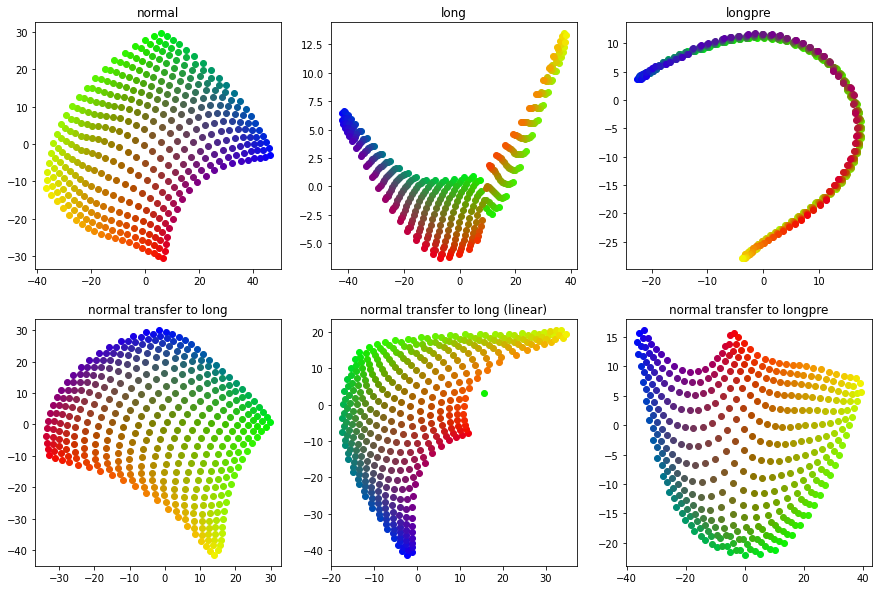

In [37]:
fig, axs = plt.subplots(2, 3, figsize=(15,10))
goal = [0.5, -0.5]
tsne_plot(normal_encoder, "normal", goal, axs[0][0])
tsne_plot(long_encoder, "long",goal, axs[0][1])
tsne_plot(longpre_encoder, "long", goal, axs[0][2])
tsne_plot(long_transfer_encoder, "long", goal, axs[1][0])
tsne_plot(long_transfer_linear_encoder, "long", goal, axs[1][1])
tsne_plot(longpre_transfer_encoder, "longpre", goal, axs[1][2])
axs[0][0].set_title("normal")
axs[0][1].set_title("long")
axs[0][2].set_title("longpre")
axs[1][0].set_title("normal transfer to long")
axs[1][1].set_title("normal transfer to long (linear)")
axs[1][2].set_title("normal transfer to longpre")

INFO:tensorflow:Restoring parameters from ./transfer_results/model_long_s3/Simple/encoding.ckpt


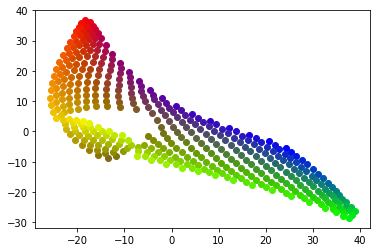

In [29]:
long_encoder = Encoder("./transfer_results/model_long_s3/Simple", h_size = 64, feature_size = 32,
                    num_layers = 2, input_size = 14)
tsne_plot(long_encoder, "long", [1,1], plt)

INFO:tensorflow:Restoring parameters from ./transfer_results/normal_transfer_to_long_s2/Simple/encoding.ckpt


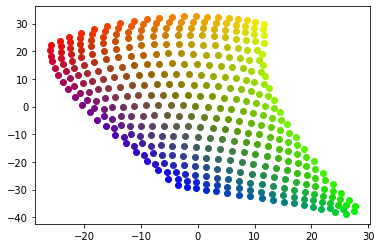

In [28]:
long_transfer_encoder_1 = Encoder("./transfer_results/normal_transfer_to_long_s2/Simple", h_size = 64, feature_size = 32,
                    num_layers = 2, input_size = 14)
tsne_plot(long_transfer_encoder_1, "long", [1,1], plt)

In [5]:
encoder_normal_hard = Encoder("./transfer_results/model_normal_s0/Simple",
                    h_size = 32,
                    feature_size = 2,
                    num_layers = 1,
                    input_size = 4)

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
---build encoder---
<tf.Variable 'encoding/main_graph_0/hidden_0/kernel:0' shape=(4, 32) dtype=float32_ref>
<tf.Variable 'encoding/main_graph_0/hidden_0/bias:0' shape=(32,) dtype=float32_ref>
<tf.Variable 'encoding/latent/kernel:0' shape=(32, 2) dtype=float32_ref>
<tf.Variable 'encoding/latent/bias:0' shape=(2,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from ./transfer_results/model_normal_s0/Simple/encoding.ckpt
loaded from path ./transfer_results/model_normal_s0/Simple


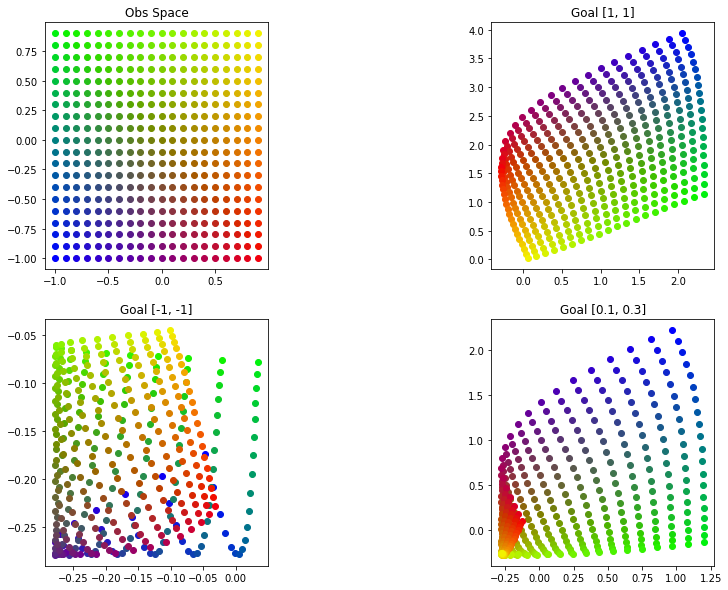

In [44]:
plot_features(encoder_normal_hard)

In [31]:
encoder_rich1_hard = Encoder("./transfer_results/model_rich1_s0/Simple",
                    h_size = 32,
                    feature_size = 2,
                    num_layers = 1,
                    input_size = 5)

---build encoder---
<tf.Variable 'encoding/main_graph_0/hidden_0/kernel:0' shape=(5, 32) dtype=float32_ref>
<tf.Variable 'encoding/main_graph_0/hidden_0/bias:0' shape=(32,) dtype=float32_ref>
<tf.Variable 'encoding/latent/kernel:0' shape=(32, 2) dtype=float32_ref>
<tf.Variable 'encoding/latent/bias:0' shape=(2,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from ./transfer_results/model_rich1_s0/Simple/encoding.ckpt
loaded from path ./transfer_results/model_rich1_s0/Simple


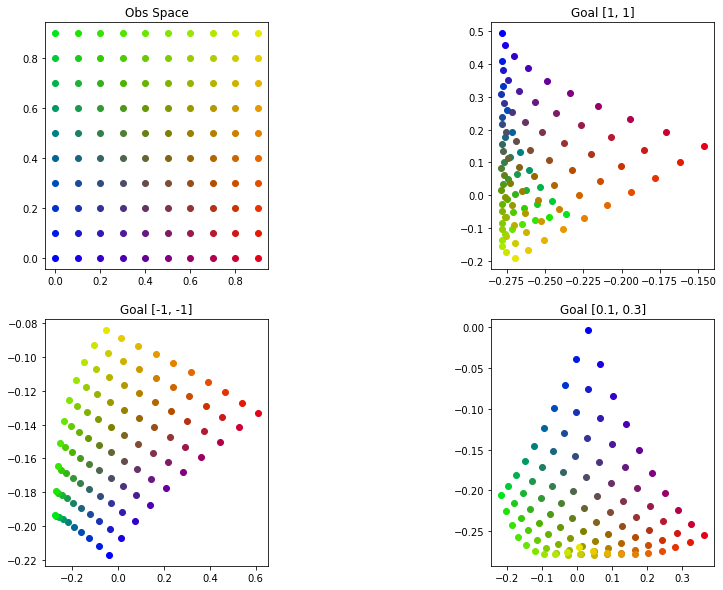

In [32]:
plot_features(encoder_rich1_hard, "rich1")

In [33]:
encoder_rich2_hard = Encoder("./transfer_results/model_rich2_s0/Simple",
                    h_size = 32,
                    feature_size = 2,
                    num_layers = 1,
                    input_size = 5)

---build encoder---
<tf.Variable 'encoding/main_graph_0/hidden_0/kernel:0' shape=(5, 32) dtype=float32_ref>
<tf.Variable 'encoding/main_graph_0/hidden_0/bias:0' shape=(32,) dtype=float32_ref>
<tf.Variable 'encoding/latent/kernel:0' shape=(32, 2) dtype=float32_ref>
<tf.Variable 'encoding/latent/bias:0' shape=(2,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from ./transfer_results/model_rich2_s0/Simple/encoding.ckpt
loaded from path ./transfer_results/model_rich2_s0/Simple


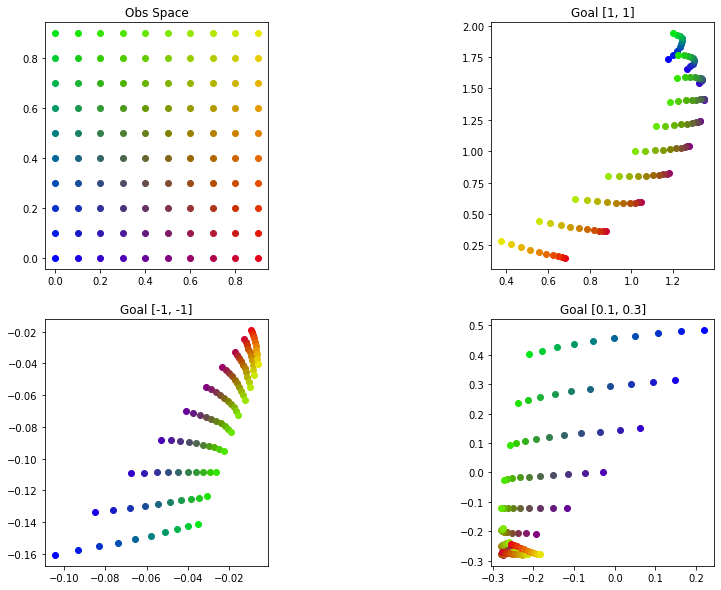

In [34]:
plot_features(encoder_rich2_hard, "rich2")

---build encoder---
<tf.Variable 'encoding/main_graph_0/hidden_0/kernel:0' shape=(5, 32) dtype=float32_ref>
<tf.Variable 'encoding/main_graph_0/hidden_0/bias:0' shape=(32,) dtype=float32_ref>
<tf.Variable 'encoding/latent/kernel:0' shape=(32, 2) dtype=float32_ref>
<tf.Variable 'encoding/latent/bias:0' shape=(2,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from ./transfer_results/transfer_rich1_from-normal_s0/Simple/encoding.ckpt
loaded from path ./transfer_results/transfer_rich1_from-normal_s0/Simple


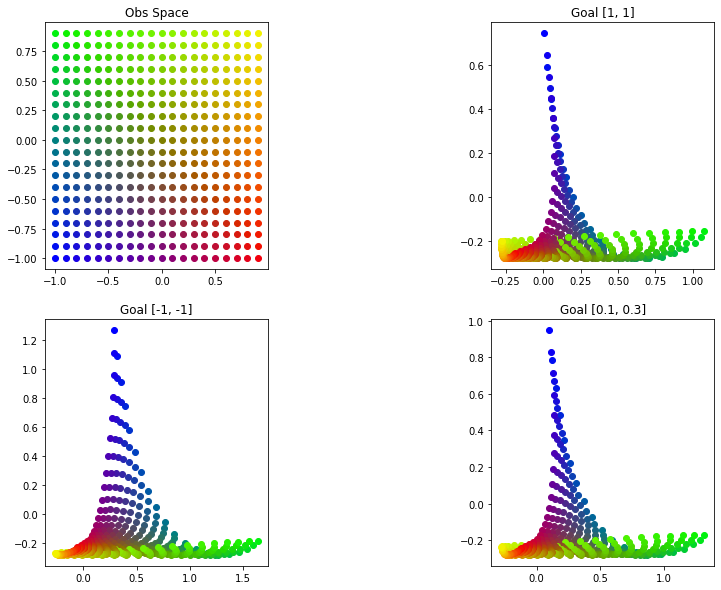

In [62]:
encoder_rich1_hard_transfer = Encoder("./transfer_results/transfer_rich1_from-normal_s0/Simple",
                    h_size = 32,
                    feature_size = 2,
                    num_layers = 1,
                    input_size = 5)
plot_features(encoder_rich1_hard_transfer, "rich1")

---build encoder---
<tf.Variable 'encoding/main_graph_0/hidden_0/kernel:0' shape=(4, 32) dtype=float32_ref>
<tf.Variable 'encoding/main_graph_0/hidden_0/bias:0' shape=(32,) dtype=float32_ref>
<tf.Variable 'encoding/latent/kernel:0' shape=(32, 2) dtype=float32_ref>
<tf.Variable 'encoding/latent/bias:0' shape=(2,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from ./transfer_results_old/model_normal_easy_s0/Simple/encoding.ckpt
loaded from path ./transfer_results_old/model_normal_easy_s0/Simple


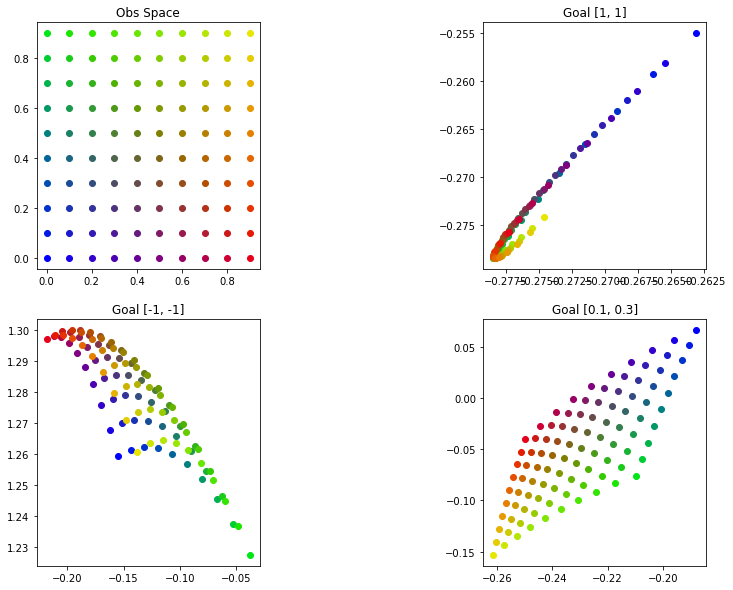

In [39]:
encoder_normal_easy = Encoder("./transfer_results_old/model_normal_easy_s0/Simple",
                    h_size = 32,
                    feature_size = 2,
                    num_layers = 1,
                    input_size = 4)
plot_features(encoder_normal_easy, "normal")

---build encoder---
<tf.Variable 'encoding/main_graph_0/hidden_0/kernel:0' shape=(4, 32) dtype=float32_ref>
<tf.Variable 'encoding/main_graph_0/hidden_0/bias:0' shape=(32,) dtype=float32_ref>
<tf.Variable 'encoding/latent/kernel:0' shape=(32, 2) dtype=float32_ref>
<tf.Variable 'encoding/latent/bias:0' shape=(2,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from ./transfer_results_old/modelbased_normal_opbuf_ibalter_s0/Simple/encoding.ckpt
loaded from path ./transfer_results_old/modelbased_normal_opbuf_ibalter_s0/Simple


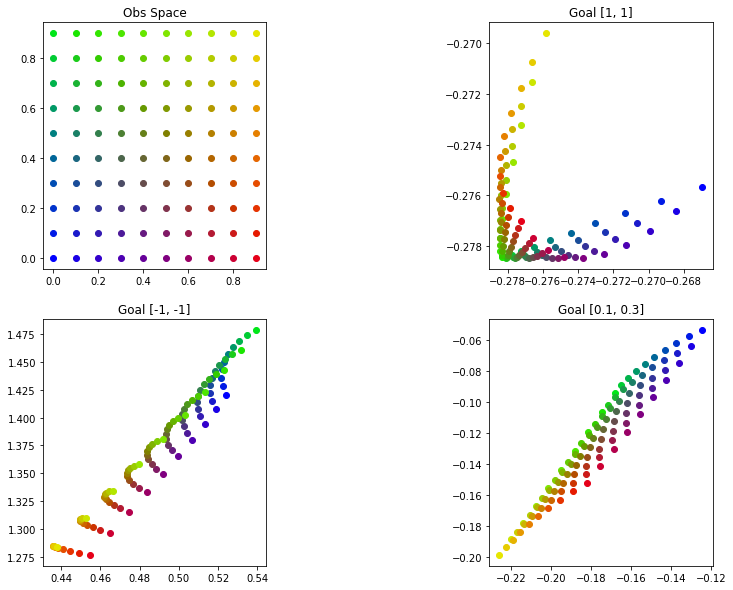

In [40]:
encoder_normal_easy2 = Encoder("./transfer_results_old/modelbased_normal_opbuf_ibalter_s0/Simple",
                    h_size = 32,
                    feature_size = 2,
                    num_layers = 1,
                    input_size = 4)
plot_features(encoder_normal_easy2, "normal")

---build encoder---
<tf.Variable 'encoding/main_graph_0/hidden_0/kernel:0' shape=(5, 32) dtype=float32_ref>
<tf.Variable 'encoding/main_graph_0/hidden_0/bias:0' shape=(32,) dtype=float32_ref>
<tf.Variable 'encoding/latent/kernel:0' shape=(32, 2) dtype=float32_ref>
<tf.Variable 'encoding/latent/bias:0' shape=(2,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from ./transfer_results_old/modelbased_rich_opbuf_ibalter_s0/Simple/encoding.ckpt
loaded from path ./transfer_results_old/modelbased_rich_opbuf_ibalter_s0/Simple


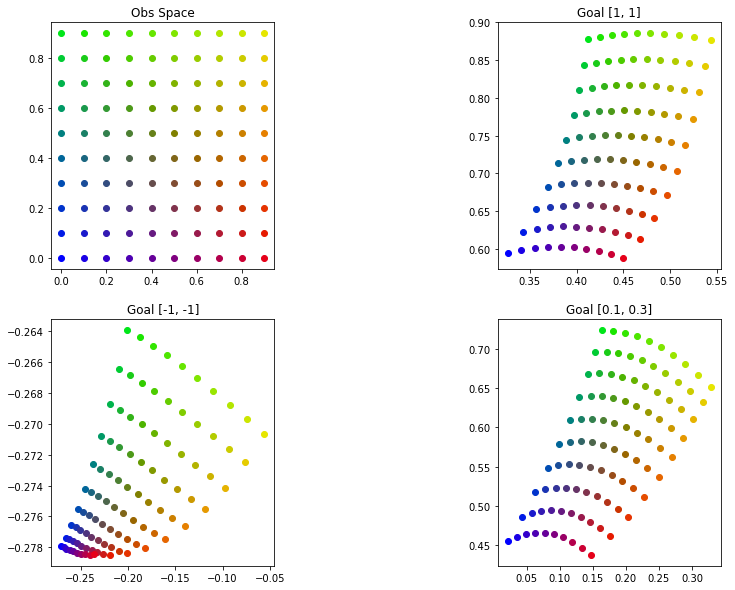

In [37]:
encoder_rich1_easy = Encoder("./transfer_results_old/modelbased_rich_opbuf_ibalter_s0/Simple",
                    h_size = 32,
                    feature_size = 2,
                    num_layers = 1,
                    input_size = 5)
plot_features(encoder_rich1_easy, "rich1")

---build encoder---
<tf.Variable 'encoding/main_graph_0/hidden_0/kernel:0' shape=(5, 32) dtype=float32_ref>
<tf.Variable 'encoding/main_graph_0/hidden_0/bias:0' shape=(32,) dtype=float32_ref>
<tf.Variable 'encoding/latent/kernel:0' shape=(32, 2) dtype=float32_ref>
<tf.Variable 'encoding/latent/bias:0' shape=(2,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from ./transfer_results_old/transfer_rich1_from-normal_s0/Simple/encoding.ckpt
loaded from path ./transfer_results_old/transfer_rich1_from-normal_s0/Simple


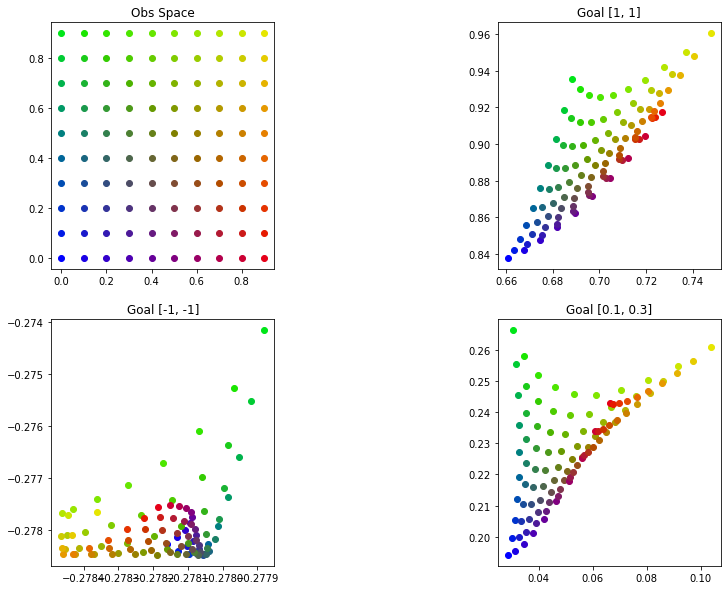

In [38]:
encoder_rich1_easy_transfer = Encoder("./transfer_results_old/transfer_rich1_from-normal_s0/Simple",
                    h_size = 32,
                    feature_size = 2,
                    num_layers = 1,
                    input_size = 5)
plot_features(encoder_rich1_easy_transfer, "rich1")

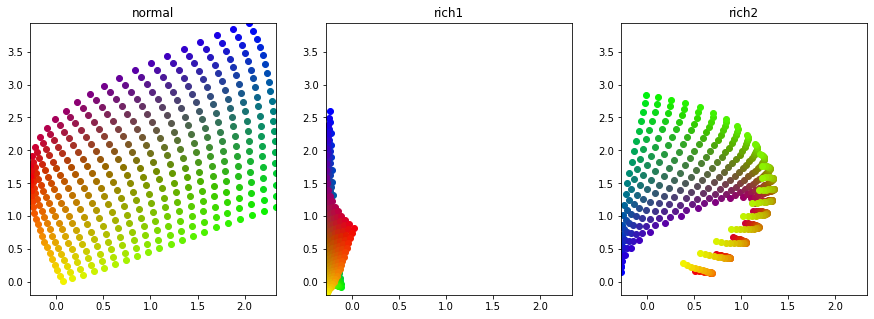

In [81]:
compare_plots([encoder_normal_hard, encoder_rich1_hard, encoder_rich2_hard],
                ["normal", "rich1", "rich2"], [1., 1.])

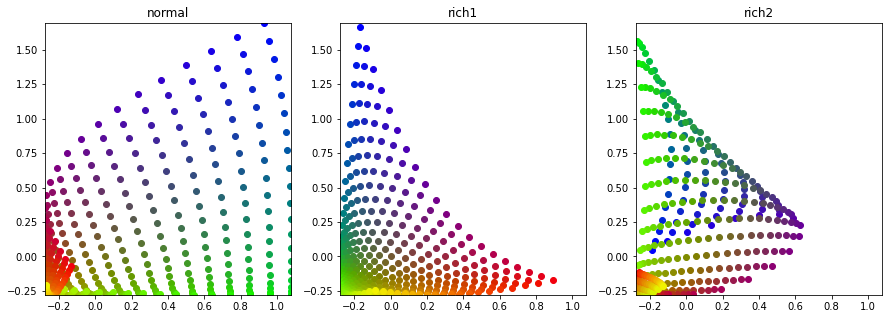

In [82]:
compare_plots([encoder_normal_hard, encoder_rich1_hard, encoder_rich2_hard],
                ["normal", "rich1", "rich2"], [0, 0])

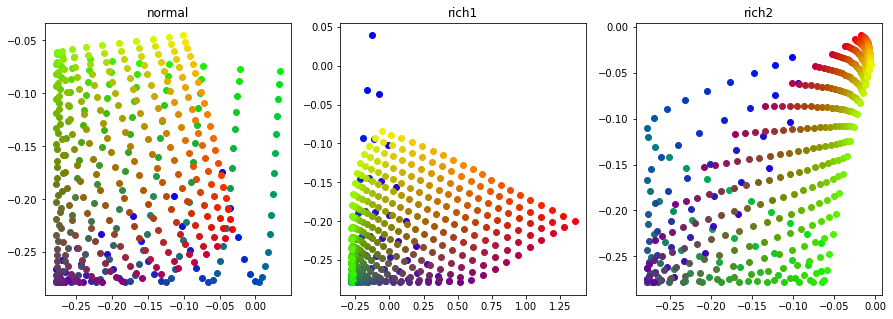

In [56]:
compare_plots([encoder_normal_hard, encoder_rich1_hard, encoder_rich2_hard],
                ["normal", "rich1", "rich2"], [-1., -1.])

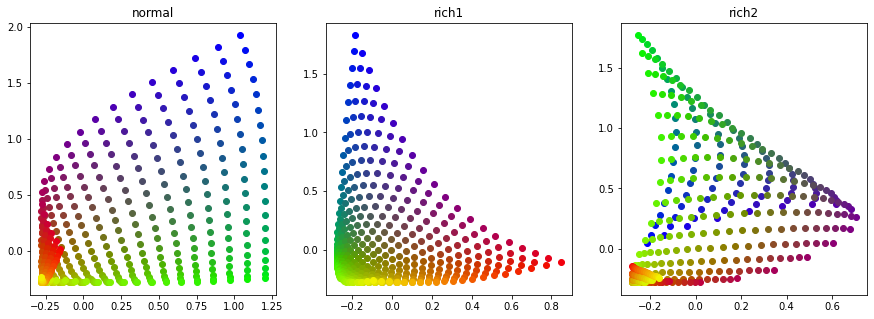

In [58]:
compare_plots([encoder_normal_hard, encoder_rich1_hard, encoder_rich2_hard],
                ["normal", "rich1", "rich2"], [0.1, 0.1])

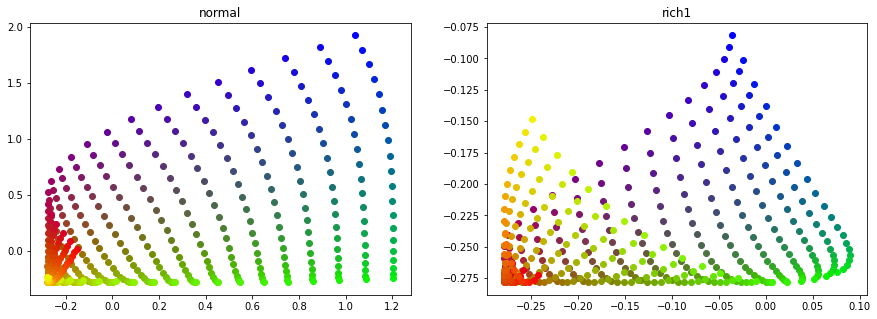

In [60]:
compare_plots([encoder_normal_hard, encoder_rich1_transfer],
                ["normal", "rich1"], [0.1, 0.1])

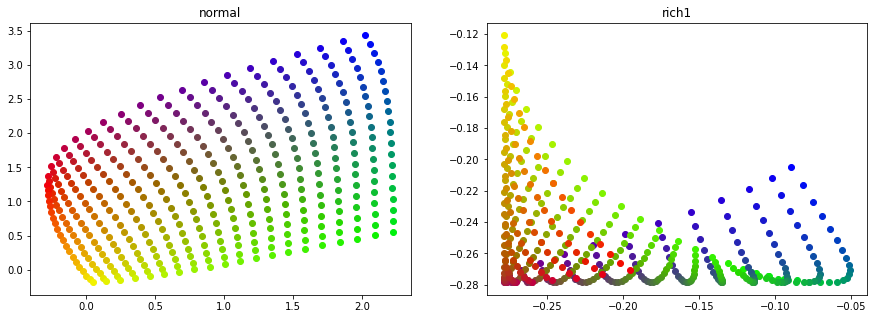

In [61]:
compare_plots([encoder_normal_hard, encoder_rich1_transfer],
                ["normal", "rich1"], [0.9, 0.7])

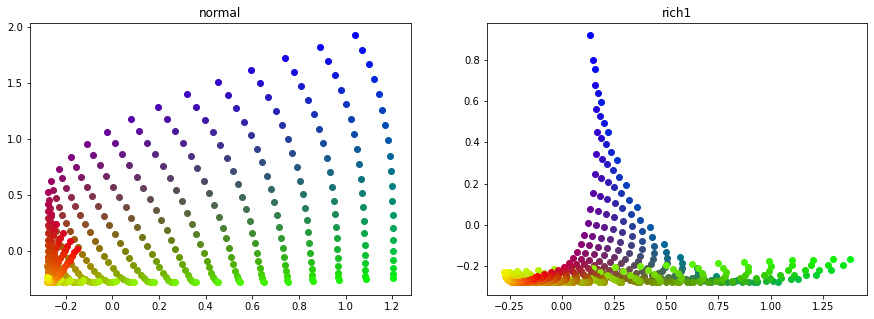

In [63]:
compare_plots([encoder_normal_hard, encoder_rich1_hard_transfer],
                ["normal", "rich1"], [0.1, 0.1])

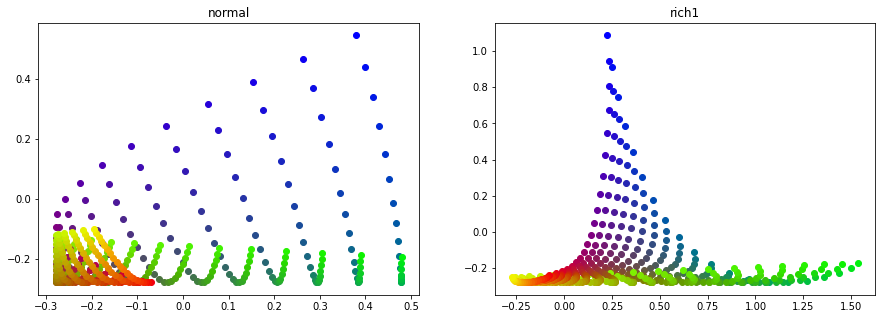

In [65]:
compare_plots([encoder_normal_hard, encoder_rich1_hard_transfer],
                ["normal", "rich1"], [-0.5, -0.5])

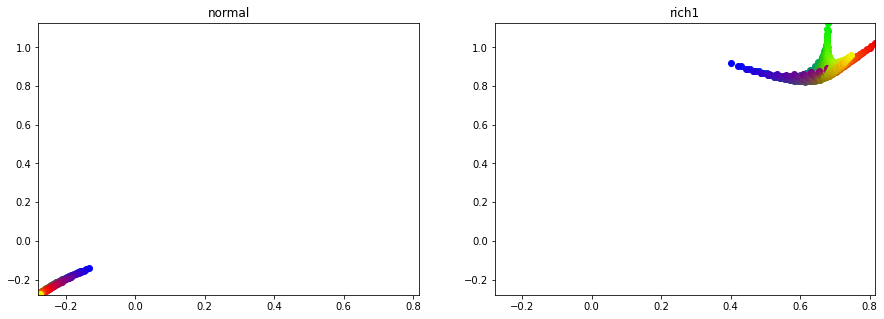

In [85]:
compare_plots([encoder_normal_easy, encoder_rich1_easy_transfer],
                ["normal", "rich1"], [1,1])

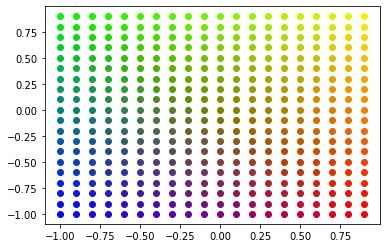

In [75]:
x = np.arange(-1,1,0.1)
y = np.arange(-1,1,0.1)
for i in x:
    for j in y:
        plt.scatter(i, j, color=my_color(i,j))
plt.show()

In [76]:
encoder_rich2_easy_transfer = Encoder("./transfer_results_old/transfer_rich2_from-rich1_s0/Simple",
                    h_size = 32,
                    feature_size = 2,
                    num_layers = 1,
                    input_size = 5)

---build encoder---
<tf.Variable 'encoding/main_graph_0/hidden_0/kernel:0' shape=(5, 32) dtype=float32_ref>
<tf.Variable 'encoding/main_graph_0/hidden_0/bias:0' shape=(32,) dtype=float32_ref>
<tf.Variable 'encoding/latent/kernel:0' shape=(32, 2) dtype=float32_ref>
<tf.Variable 'encoding/latent/bias:0' shape=(2,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from ./transfer_results_old/transfer_rich2_from-rich1_s0/Simple/encoding.ckpt
loaded from path ./transfer_results_old/transfer_rich2_from-rich1_s0/Simple


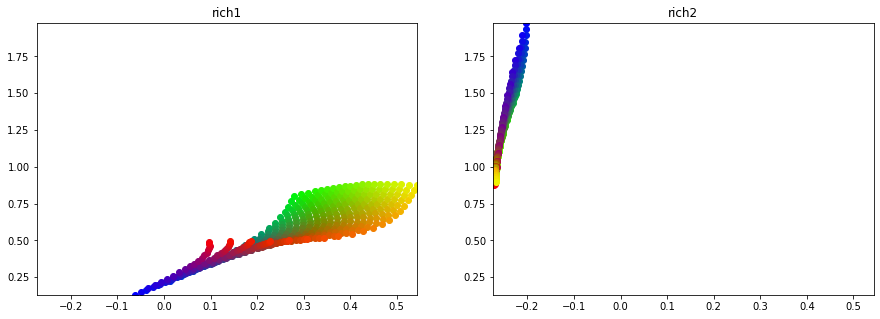

In [84]:
compare_plots([encoder_rich1_easy, encoder_rich2_easy_transfer],
                ["rich1", "rich2"], [1,1])

---build encoder---
<tf.Variable 'encoding/main_graph_0/hidden_0/kernel:0' shape=(4, 32) dtype=float32_ref>
<tf.Variable 'encoding/main_graph_0/hidden_0/bias:0' shape=(32,) dtype=float32_ref>
<tf.Variable 'encoding/latent/kernel:0' shape=(32, 2) dtype=float32_ref>
<tf.Variable 'encoding/latent/bias:0' shape=(2,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from ./transfer_results/model_normal_f2_bisim_varp_sepall_s0/Simple/encoding.ckpt
loaded from path ./transfer_results/model_normal_f2_bisim_varp_sepall_s0/Simple


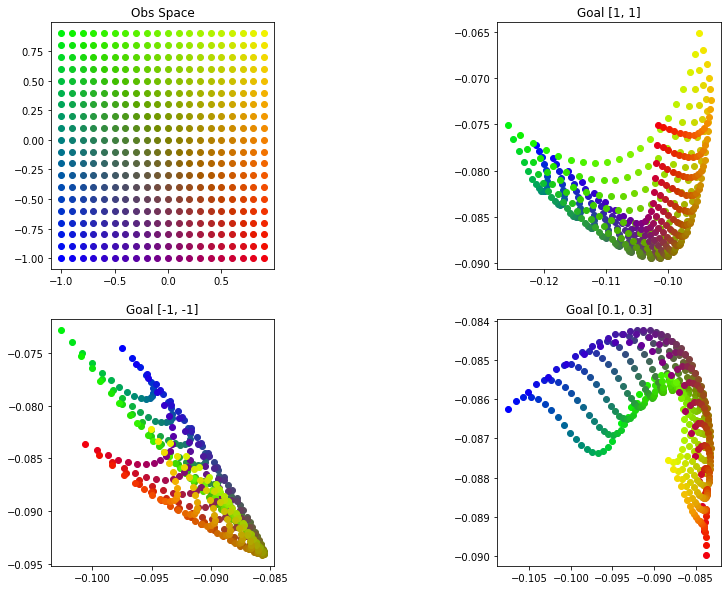

In [86]:
encoder_bisim_normal_hard = Encoder("./transfer_results/model_normal_f2_bisim_varp_sepall_s0/Simple",
                    h_size = 32,
                    feature_size = 2,
                    num_layers = 1,
                    input_size = 4)
plot_features(encoder_bisim_normal_hard, "normal")

---build encoder---
<tf.Variable 'encoding/main_graph_0/hidden_0/kernel:0' shape=(4, 32) dtype=float32_ref>
<tf.Variable 'encoding/main_graph_0/hidden_0/bias:0' shape=(32,) dtype=float32_ref>
<tf.Variable 'encoding/latent/kernel:0' shape=(32, 2) dtype=float32_ref>
<tf.Variable 'encoding/latent/bias:0' shape=(2,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from ./transfer_results/model_normal_f2_bisim_varp_sepall_5e-4_s0/Simple/encoding.ckpt
loaded from path ./transfer_results/model_normal_f2_bisim_varp_sepall_5e-4_s0/Simple


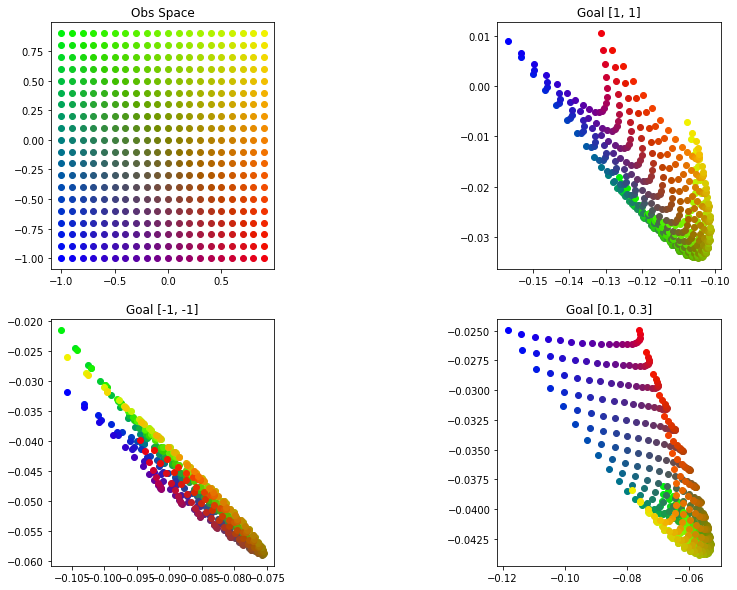

In [88]:
encoder_bisim_normal_hard1 = Encoder("./transfer_results/model_normal_f2_bisim_varp_sepall_5e-4_s0/Simple",
                    h_size = 32,
                    feature_size = 2,
                    num_layers = 1,
                    input_size = 4)
plot_features(encoder_bisim_normal_hard1, "normal")

---build encoder---
<tf.Variable 'encoding/main_graph_0/hidden_0/kernel:0' shape=(5, 32) dtype=float32_ref>
<tf.Variable 'encoding/main_graph_0/hidden_0/bias:0' shape=(32,) dtype=float32_ref>
<tf.Variable 'encoding/latent/kernel:0' shape=(32, 2) dtype=float32_ref>
<tf.Variable 'encoding/latent/bias:0' shape=(2,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from ./transfer_results/model_rich1_f2_bisim_varp_sepall_s0/Simple/encoding.ckpt
loaded from path ./transfer_results/model_rich1_f2_bisim_varp_sepall_s0/Simple


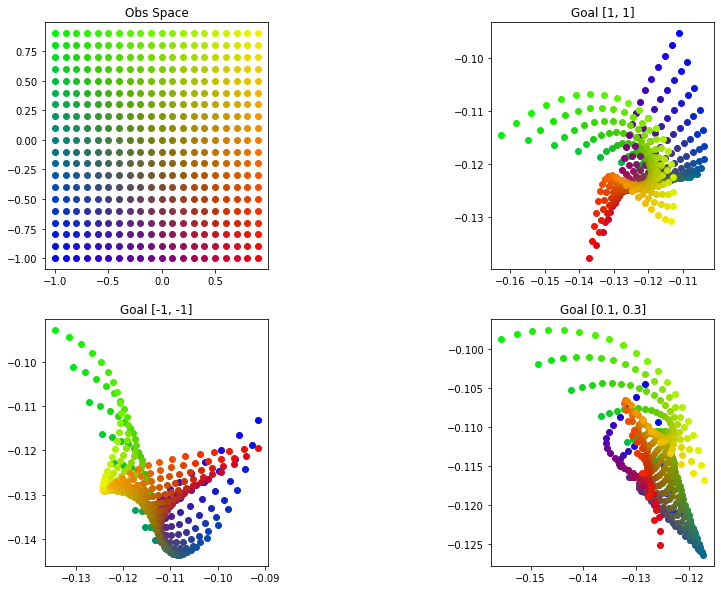

In [87]:
encoder_bisim_rich1_hard = Encoder("./transfer_results/model_rich1_f2_bisim_varp_sepall_s0/Simple",
                    h_size = 32,
                    feature_size = 2,
                    num_layers = 1,
                    input_size = 5)
plot_features(encoder_bisim_rich1_hard, "rich1")

---build encoder---
<tf.Variable 'encoding/main_graph_0/hidden_0/kernel:0' shape=(5, 32) dtype=float32_ref>
<tf.Variable 'encoding/main_graph_0/hidden_0/bias:0' shape=(32,) dtype=float32_ref>
<tf.Variable 'encoding/latent/kernel:0' shape=(32, 2) dtype=float32_ref>
<tf.Variable 'encoding/latent/bias:0' shape=(2,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from ./transfer_results/model_rich2_f2_bisim_varp_sepall_s0/Simple/encoding.ckpt
loaded from path ./transfer_results/model_rich2_f2_bisim_varp_sepall_s0/Simple


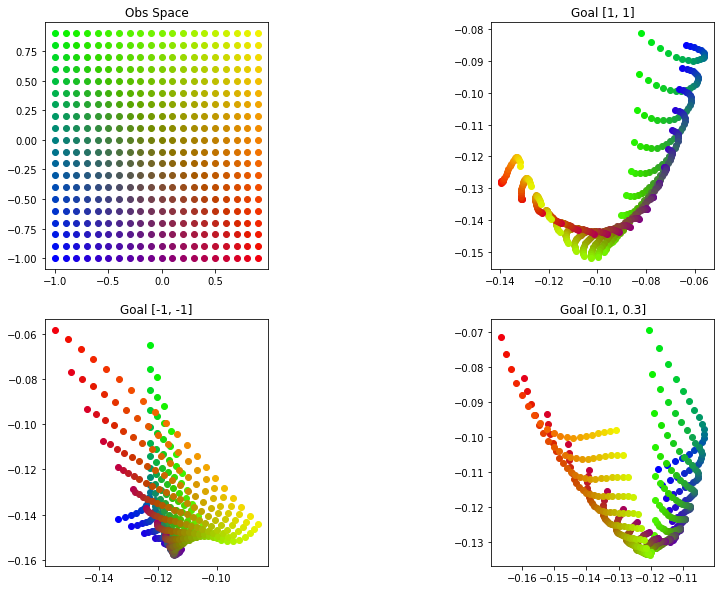

In [89]:
encoder_bisim_rich2_hard = Encoder("./transfer_results/model_rich2_f2_bisim_varp_sepall_s0/Simple",
                    h_size = 32,
                    feature_size = 2,
                    num_layers = 1,
                    input_size = 5)
plot_features(encoder_bisim_rich2_hard, "rich2")

---build encoder---
<tf.Variable 'encoding/main_graph_0/hidden_0/kernel:0' shape=(5, 32) dtype=float32_ref>
<tf.Variable 'encoding/main_graph_0/hidden_0/bias:0' shape=(32,) dtype=float32_ref>
<tf.Variable 'encoding/latent/kernel:0' shape=(32, 2) dtype=float32_ref>
<tf.Variable 'encoding/latent/bias:0' shape=(2,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from ./transfer_results/model_rich1_f2_pv-l0_inverse_s0/Simple/encoding.ckpt
loaded from path ./transfer_results/model_rich1_f2_pv-l0_inverse_s0/Simple


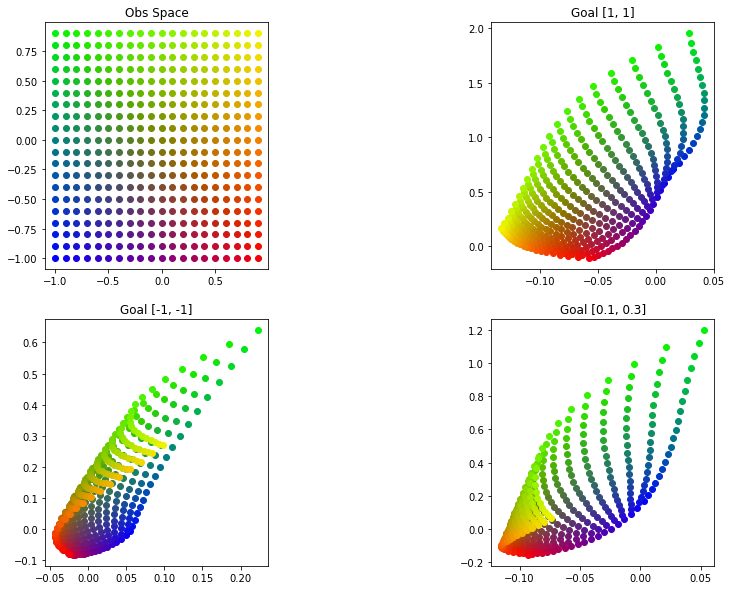

In [91]:
encoder_inverse_rich1_hard = Encoder("./transfer_results/model_rich1_f2_pv-l0_inverse_s0/Simple",
                    h_size = 32,
                    feature_size = 2,
                    num_layers = 1,
                    input_size = 5)
plot_features(encoder_inverse_rich1_hard, "rich1")

---build encoder---
<tf.Variable 'encoding/main_graph_0/hidden_0/kernel:0' shape=(4, 32) dtype=float32_ref>
<tf.Variable 'encoding/main_graph_0/hidden_0/bias:0' shape=(32,) dtype=float32_ref>
<tf.Variable 'encoding/latent/kernel:0' shape=(32, 2) dtype=float32_ref>
<tf.Variable 'encoding/latent/bias:0' shape=(2,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from ./transfer_results/model_normal_f2_pv-l0_inverse_s0/Simple/encoding.ckpt
loaded from path ./transfer_results/model_normal_f2_pv-l0_inverse_s0/Simple


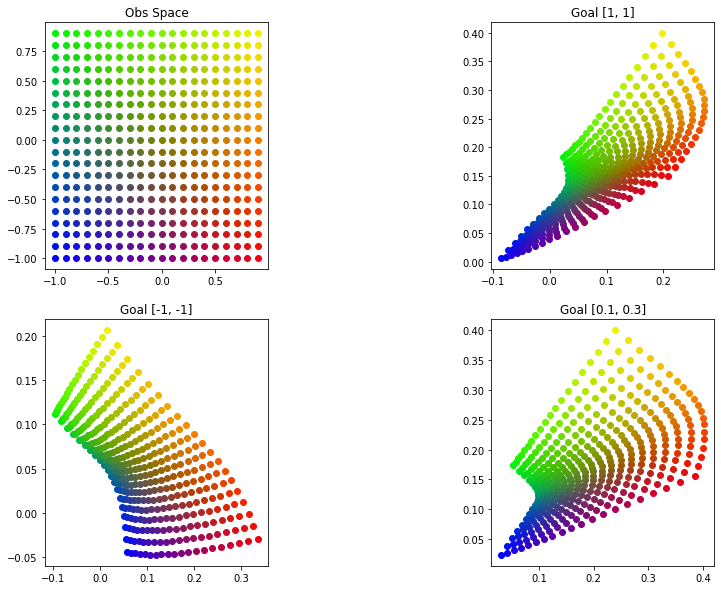

In [92]:
encoder_inverse_normal_hard = Encoder("./transfer_results/model_normal_f2_pv-l0_inverse_s0/Simple",
                    h_size = 32,
                    feature_size = 2,
                    num_layers = 1,
                    input_size = 4)
plot_features(encoder_inverse_normal_hard, "normal")

---build encoder---
<tf.Variable 'encoding/main_graph_0/hidden_0/kernel:0' shape=(5, 32) dtype=float32_ref>
<tf.Variable 'encoding/main_graph_0/hidden_0/bias:0' shape=(32,) dtype=float32_ref>
<tf.Variable 'encoding/latent/kernel:0' shape=(32, 2) dtype=float32_ref>
<tf.Variable 'encoding/latent/bias:0' shape=(2,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from ./transfer_results/model_rich1_f2_pv-l0_inverse_s0/Simple/encoding.ckpt
loaded from path ./transfer_results/model_rich1_f2_pv-l0_inverse_s0/Simple


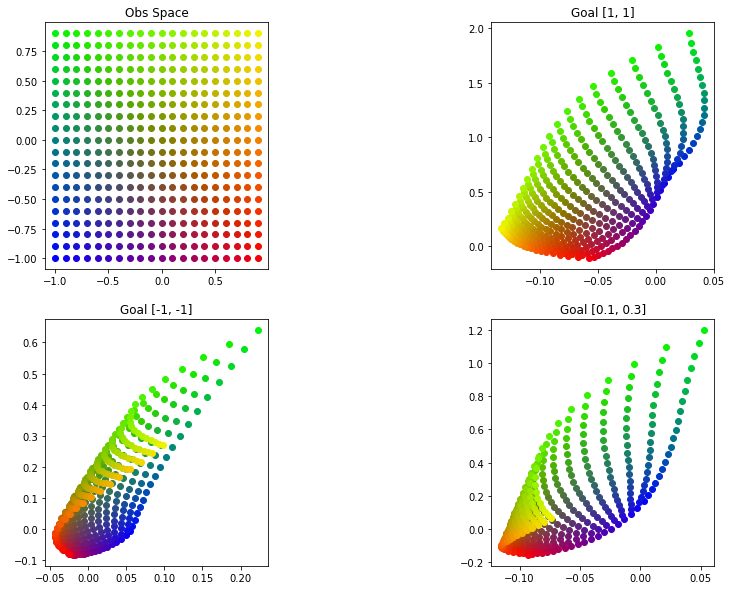

In [93]:
encoder_inverse_rich1_hard = Encoder("./transfer_results/model_rich1_f2_pv-l0_inverse_s0/Simple",
                    h_size = 32,
                    feature_size = 2,
                    num_layers = 1,
                    input_size = 5)
plot_features(encoder_inverse_rich1_hard, "rich1")

---build encoder---
<tf.Variable 'encoding/main_graph_0/hidden_0/kernel:0' shape=(4, 32) dtype=float32_ref>
<tf.Variable 'encoding/main_graph_0/hidden_0/bias:0' shape=(32,) dtype=float32_ref>
<tf.Variable 'encoding/latent/kernel:0' shape=(32, 2) dtype=float32_ref>
<tf.Variable 'encoding/latent/bias:0' shape=(2,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from ./transfer_results/model_normal_easy_f2_pv-l0_inverse_s0/Simple/encoding.ckpt
loaded from path ./transfer_results/model_normal_easy_f2_pv-l0_inverse_s0/Simple


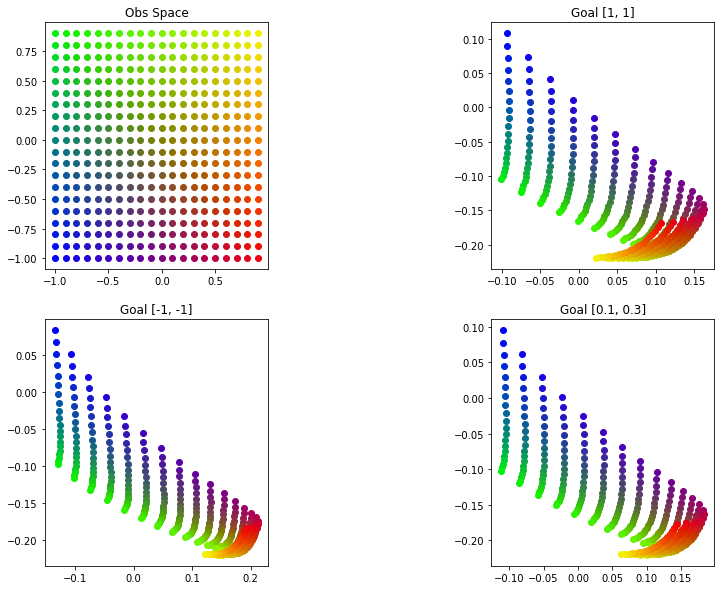

In [94]:
encoder_inverse_normal_easy = Encoder("./transfer_results/model_normal_easy_f2_pv-l0_inverse_s0/Simple",
                    h_size = 32,
                    feature_size = 2,
                    num_layers = 1,
                    input_size = 4)
plot_features(encoder_inverse_normal_easy, "normal")

---build encoder---
<tf.Variable 'encoding/main_graph_0/hidden_0/kernel:0' shape=(5, 32) dtype=float32_ref>
<tf.Variable 'encoding/main_graph_0/hidden_0/bias:0' shape=(32,) dtype=float32_ref>
<tf.Variable 'encoding/latent/kernel:0' shape=(32, 2) dtype=float32_ref>
<tf.Variable 'encoding/latent/bias:0' shape=(2,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from ./transfer_results/model_rich1_easy_f2_pv-l0_inverse_s0/Simple/encoding.ckpt
loaded from path ./transfer_results/model_rich1_easy_f2_pv-l0_inverse_s0/Simple


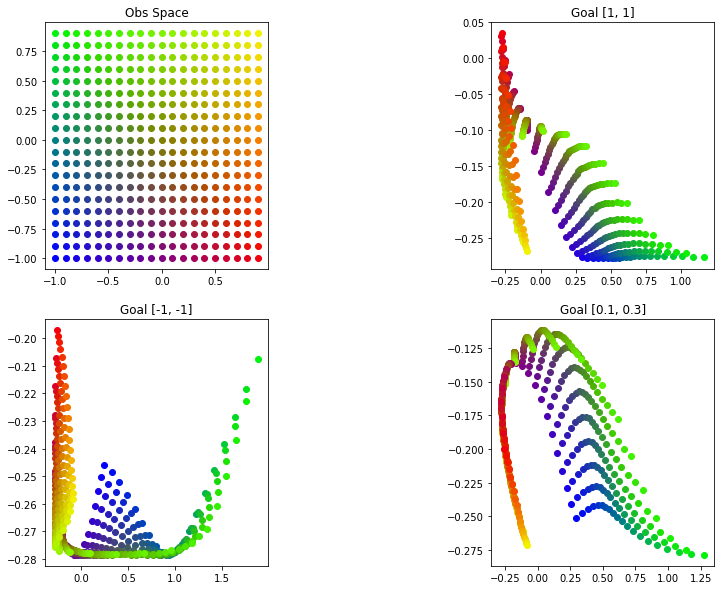

In [95]:
encoder_inverse_rich1_easy = Encoder("./transfer_results/model_rich1_easy_f2_pv-l0_inverse_s0/Simple",
                    h_size = 32,
                    feature_size = 2,
                    num_layers = 1,
                    input_size = 5)
plot_features(encoder_inverse_rich1_easy, "rich1")

In [96]:
encoder_inverse_rich2_easy = Encoder("./transfer_results/model_rich2_easy_f2_pv-l0_inverse_s0/Simple",
                    h_size = 32,
                    feature_size = 2,
                    num_layers = 1,
                    input_size = 5)

---build encoder---
<tf.Variable 'encoding/main_graph_0/hidden_0/kernel:0' shape=(5, 32) dtype=float32_ref>
<tf.Variable 'encoding/main_graph_0/hidden_0/bias:0' shape=(32,) dtype=float32_ref>
<tf.Variable 'encoding/latent/kernel:0' shape=(32, 2) dtype=float32_ref>
<tf.Variable 'encoding/latent/bias:0' shape=(2,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from ./transfer_results/model_rich2_easy_f2_pv-l0_inverse_s0/Simple/encoding.ckpt
loaded from path ./transfer_results/model_rich2_easy_f2_pv-l0_inverse_s0/Simple


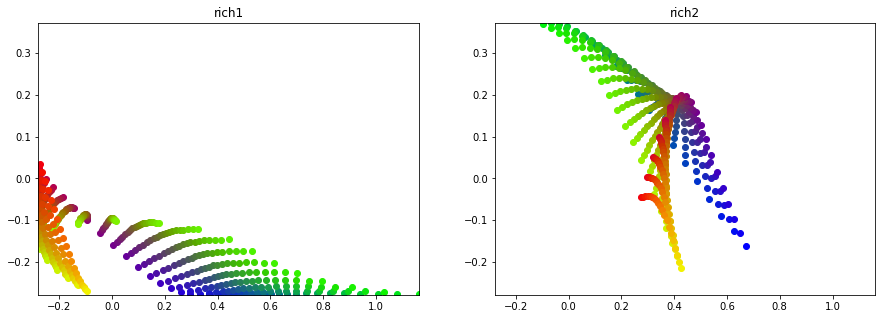

In [97]:
compare_plots([encoder_inverse_rich1_easy, encoder_inverse_rich2_easy],
                ["rich1", "rich2"], [1,1])

---build encoder---
<tf.Variable 'encoding/latent/kernel:0' shape=(4, 2) dtype=float32_ref>
<tf.Variable 'encoding/latent/bias:0' shape=(2,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from ./transfer_results/model_normal_f2_pv-l2_linear-rew_bisim_ibalter_conlr_enc-l0-op4_s0/Simple/encoding.ckpt
loaded from path ./transfer_results/model_normal_f2_pv-l2_linear-rew_bisim_ibalter_conlr_enc-l0-op4_s0/Simple


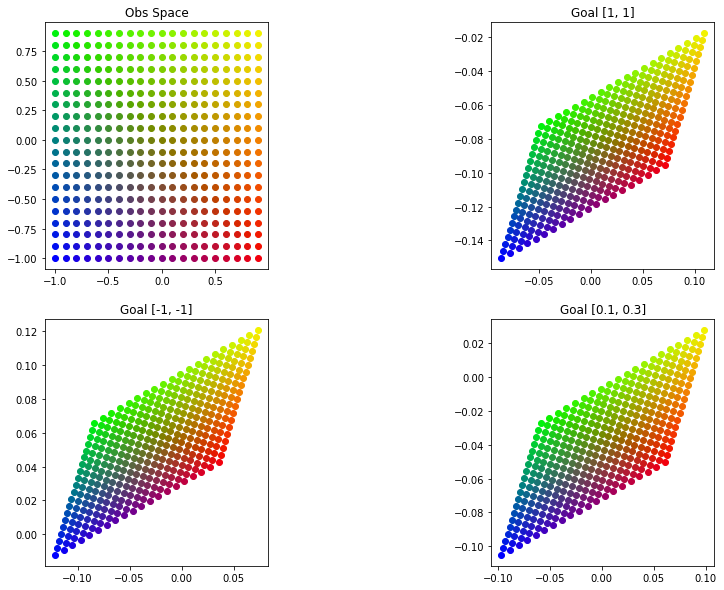

In [102]:
encoder_normal_l0 = Encoder("./transfer_results/model_normal_f2_pv-l2_linear-rew_bisim_ibalter_conlr_enc-l0-op4_s0/Simple",
                    h_size = 32,
                    feature_size = 2,
                    num_layers = 0,
                    input_size = 4)
plot_features(encoder_normal_l0, "normal")

---build encoder---
<tf.Variable 'encoding/latent/kernel:0' shape=(5, 2) dtype=float32_ref>
<tf.Variable 'encoding/latent/bias:0' shape=(2,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from ./transfer_results/model_rich1_f2_pv-l2_linear-rew_bisim_ibalter_conlr_enc-l0-op4_s0/Simple/encoding.ckpt
loaded from path ./transfer_results/model_rich1_f2_pv-l2_linear-rew_bisim_ibalter_conlr_enc-l0-op4_s0/Simple


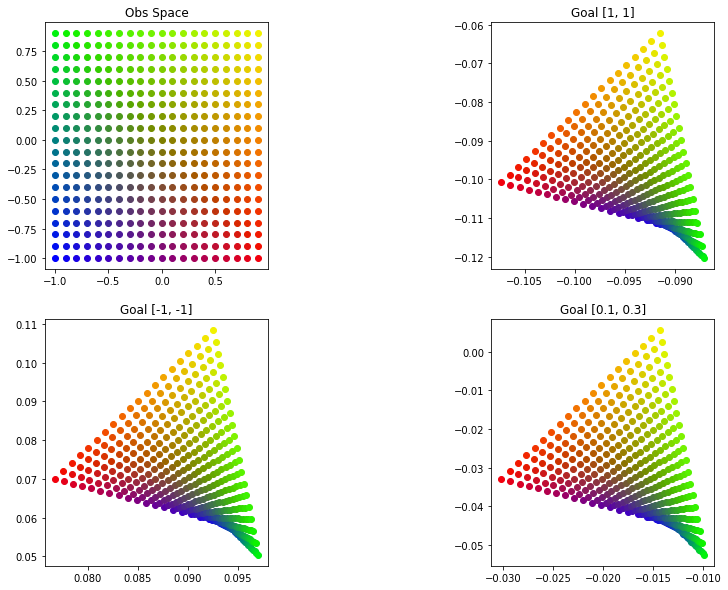

In [103]:
encoder_rich1_l0 = Encoder("./transfer_results/model_rich1_f2_pv-l2_linear-rew_bisim_ibalter_conlr_enc-l0-op4_s0/Simple",
                    h_size = 32,
                    feature_size = 2,
                    num_layers = 0,
                    input_size = 5)
plot_features(encoder_rich1_l0, "rich1")